In [1]:
from algorithm import GraphWrapper
from pathlib import Path
from tqdm import tqdm

input_path = Path('../benign_graphs/tc3-theia/firefox/nd')
input_paths = list(input_path.glob('*.json'))[:200]
input_graphs = [GraphWrapper(input_path) 
                for input_path in tqdm(input_paths, desc='Reading graphs')]
nx_graphs = [graph.to_nx() for graph in tqdm(input_graphs, desc='Converting to nx')]


Converting to nx: 100%|██████████| 200/200 [00:03<00:00, 60.21it/s]


In [2]:
import networkx as nx
from karateclub import Graph2Vec

graph2vec = Graph2Vec(
    wl_iterations=80,
    attributed=True,
    dimensions=128,
    workers=4,
    epochs=5
)

graph2vec.fit(nx_graphs)

In [4]:
len(graph2vec.get_embedding())

200

In [18]:
import pickle
from algorithm import Subgraph, IN, OUT
pruned_subgraphs: dict[str, list[Subgraph]]
with open('pruned_subgraphs.pkl', 'rb') as f:
    pruned_subgraphs = pickle.load(f)

In [19]:
from collections import Counter
graphs = Counter()
for subgraph in pruned_subgraphs[IN]:
    graphs.update([(subgraph.parent_graph.source_edge_id, subgraph.depth, len(subgraph.edges))])

graphs

Counter({(53642395, 1, 1): 514,
         (12403321, 1, 1): 510,
         (9726155, 1, 1): 509,
         (12646743, 1, 1): 507,
         (12495075, 1, 1): 507,
         (56598918, 1, 1): 503,
         (11514956, 1, 1): 502,
         (12831606, 1, 1): 501,
         (59363202, 1, 1): 501,
         (12559024, 1, 1): 500,
         (55921424, 1, 1): 499,
         (20440337, 1, 1): 498,
         (19624330, 1, 1): 498,
         (56371783, 1, 1): 497,
         (12380905, 1, 1): 496,
         (57149937, 1, 1): 495,
         (21916275, 1, 1): 491,
         (53551079, 1, 1): 491,
         (20310276, 1, 1): 490,
         (20906008, 1, 1): 489,
         (20271042, 1, 1): 489,
         (12518947, 1, 1): 485,
         (19456963, 1, 1): 481,
         (12875328, 1, 1): 479,
         (26112691, 3, 1): 437,
         (40755170, 3, 1): 388,
         (52936304, 1, 1): 364,
         (44125739, 2, 1): 348,
         (33673393, 2, 1): 318,
         (37812457, 2, 1): 303,
         (39352652, 2, 1): 297,
         

In [24]:
pruned_subgraphs[IN][0].root_edge_id

5108780

In [14]:
[s.depth for s in pruned_subgraphs[IN]]

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [13]:
[len(g.edges) for g in graphs]

[1001, 1006, 1147, 1090, 1006, 1001, 1001, 1001, 1001, 1001]

In [8]:
len(pruned_subgraphs[IN])

1335

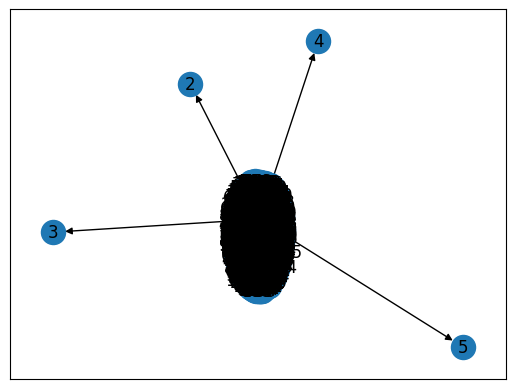

In [11]:
import matplotlib.pyplot as plt
nx.draw_networkx(G, with_labels=True)
plt.show() 